In [1]:
import random
from importlib import reload
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import seaborn as sn
import time
import frame_loader as frame_loader
import utils as utils
import augmentation as augmentation
import graph_neural_network

#### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reduced_cols = ['doppler','snr','x','y','current_frame','Label']
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq', 'Label']
selected_cols = ['doppler','snr','x','y']
SHAPE_NAMES = [0,1,2,3,4, 5]
frame_depths = [6] 
ks = [8]
num_chunks = 16
lr = 0.001
max_epoch = 100
size = 128
split = 16
EARLY_STOPPING_PATIENCE = 15
train, val, test =[],[],[]

#### Pre-processing pipeline

In [3]:
try:
    equal_point_frames = pd.read_csv(f"data/frames_{size}points_all_varied.csv", names=column_names, header=None, dtype=np.float64)
    print("File read")
except Exception as e:
    equal_point_frames = frame_loader.equal_frame_loader(column_names,size)
    print("Frames generated")

# Normalize the data
norm_frames = utils.min_max_normalization(equal_point_frames, selected_cols)

# group the data by frame numbers
all_data_grouped = norm_frames.groupby("current_frame")
print("Total number of frames: "+str(len(all_data_grouped)))
data_array = [frame.to_numpy() for (_, frame) in all_data_grouped]

# Sort the data
sorted_data = sorted(data_array,key=lambda x:x[:,4].max(axis=0))
xy_dist = [x[:,2]+x[:,3] for x in sorted_data]
xy_sort_index = [d.argsort() for d in xy_dist]
xy_sorted = np.array([frame[xy_sort_index[i]] for i, frame in enumerate(sorted_data)])

# Split the data
train, val, test = utils.split_with_chunks(xy_sorted, SHAPE_NAMES, num_chunks, 0.15, 0.15)


File read
Max features: [ 31.81039777 967.625       11.99514317   4.35285651]
Min features: [ 0.12474666  3.5         0.42650005 -9.99815711]
Total number of frames: 21282


In [4]:
reload(utils)
# Create graphs for each sets with each hyperparameter combination
train_graphs, val_graphs, test_graphs = utils.load_graphs(train, val, test, frame_depths, ks, selected_cols, \
                                                          num_chunks, size, split, device, descending=True)

Number of graphs generated with k = 8 and frame depth = 6 for type 0: 8605
Number of graphs generated with k = 8 and frame depth = 6 for type 1: 1613
Number of graphs generated with k = 8 and frame depth = 6 for type 2: 1588


#### Data augmentation

In [6]:
# augment with random graphs
augmentation_transformer = augmentation.AugmentationTransformer(size)
four_graph_loc = np.array([data.y.cpu() == 3 for data in train_graphs[0]])
four_index = np.where(four_graph_loc)[0].tolist()
four_graphs = [train_graphs[0][i] for i in four_index]

bike_graph_loc = np.array([data.y.cpu() == 5 for data in train_graphs[0]])
bike_index = np.where(bike_graph_loc)[0].tolist()
bike_graphs = [train_graphs[0][i] for i in bike_index]

indexes = np.arange(len(train_graphs[0])).tolist()
random.seed(42)
sample_train = random.sample(indexes, 1000)
sample_train = [train_graphs[0][i] for i in sample_train]

augmented_graphs = augmentation_transformer(sample_train)
train_graphs[0].extend(augmented_graphs)

# augment with random graphs from 4 people
indexes = np.arange(len(four_graphs)).tolist()
random.seed(42)
sample_four = random.sample(indexes, 400)
sample_four = [four_graphs[i] for i in sample_four]

augmented_four = augmentation_transformer(sample_four)
train_graphs[0].extend(augmented_four)

# augment with random graphs from bikes
indexes = np.arange(len(bike_graphs)).tolist()
random.seed(42)
sample_bike = random.sample(indexes, 100)
sample_bike = [bike_graphs[i] for i in sample_bike]

augmented_bike = augmentation_transformer(sample_bike)
train_graphs[0].extend(augmented_bike)


In [8]:
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Batch the sets
for i in range(len(train_graphs)):
    random.seed(42)
    random.shuffle(train_graphs[i])
    random.seed(42)
    random.shuffle(test_graphs[i])
    random.seed(42)
    random.shuffle(val_graphs[i])
    
    train_dataloaders.append(DataLoader(train_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))


#### Train the model

In [9]:
reload(graph_neural_network)
models = []

for i, train_dataloader in enumerate(train_dataloaders):
    val_accuracies = []
    start_time = time.time()
    k = ks[i % len(ks)]
    model = graph_neural_network.Net(6, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_acc = -1
    losses = []
    accuracies = []
    for epoch in range(max_epoch):
        correct = 0
        count = 0
        model.train()
        for train_batch in train_dataloader:
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            out = model(train_batch)
            pred = out.argmax(dim=1)
            correct += (pred == train_batch.y).sum()
            loss = F.nll_loss(out, train_batch.y)
            losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            count += len(train_batch)
        acc = int(correct) / count
        losses.append(loss.detach())
        accuracies.append(acc)
        scheduler.step()

        model.eval()
        val_correct = 0
        for val_batch in val_dataloaders[i]:
            val_batch = val_batch.to(device)
            pred = model(val_batch).argmax(dim=1)
            
            val_correct += (pred == val_batch.y).sum()
        val_acc = int(val_correct) / len(val_dataloaders[i].dataset)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            
            last_improvement = 0
        else:
            last_improvement += 1

        if last_improvement > EARLY_STOPPING_PATIENCE:
            break
    
    models.append(model)
    torch.save(model, f"data/trained_model_k{k}_frame_depth{frame_depths[int(i/len(ks))]}_normalized_extended_chunk{num_chunks}.pt")
    losses = [tensor.cpu().numpy() for tensor in losses]
    print(f"trained: {i}")

    plt.plot(accuracies, label = "train")
    plt.plot(val_accuracies, label = "validation")
    plt.title(f"Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.ylim(0,1)
    plt.legend() 
    plt.show()

    plt.plot(losses)
    plt.title(f"Loss of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

    print("Training accuracy: "+str(accuracies[-1]))
    print("Training loss: "+str(losses[-1]))
    
    print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {val_accuracies[-1]:.4f}')
    print("--- %s seconds ---" % (time.time() - start_time))
    print(f"evaluated: {i}")

#### Evaluate the model on the test set

In [11]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in test_dataloaders[i]:
    test_batch = test_batch.to(device)
    pred = model(test_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    
    correct += (pred == test_batch.y).sum()
acc = int(correct) / len(test_graphs[i])
print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

Accuracy of the model with k = 2 and frame depth = 4: 0.7768


#### Confusion matrix

/tmp/ipykernel_758271/2461249739.py:5: RuntimeWarning: invalid value encountered in divide
  cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])


Text(0.5, 14.722222222222216, 'Predicated Label')

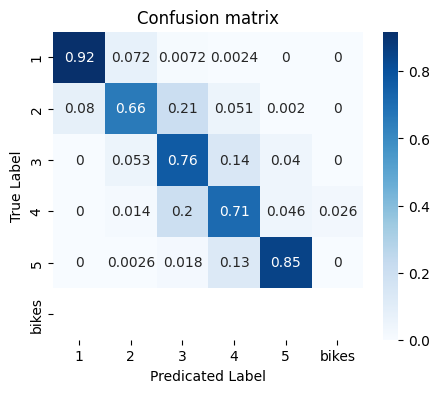

In [12]:
SHAPE_LABELS = [1,2,3,4,5,"bikes"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

#### Distribution of the train data

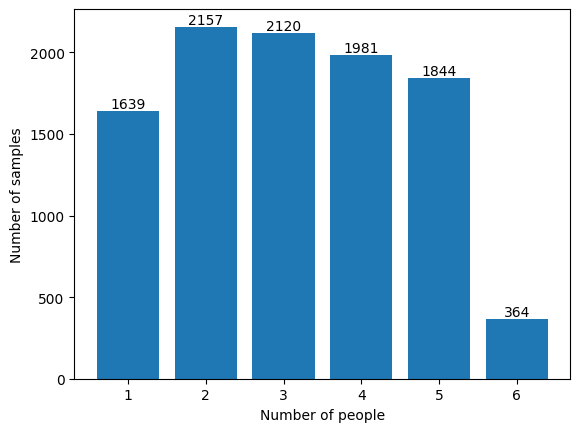

In [7]:
data_points = np.array([d.y.item() for d in train_graphs[0]])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
bikes = len(np.where(data_points  == 5)[0])

labels = [1,2,3,4,5, 6]
sample_num = [zeros, ones, twos, threes, fours,bikes]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()